# Set directory to wherever the project is housed

In [1]:
import sys
sys.path.append('C:/users/ahaberlie/documents/github/MCS/')

# Download track data for plotting:

Download data.tar.gz from https://tiny.cc/ + the full manuscript ID for part 1 (case sensitive), and untar and ungzip this into the directory "MCS/mcs" and make sure the output folder is "data" and it has a folder named "track_data". Examine the code to see the proper location if you are getting an error (i.e., "../data/track_data/")

# Set up utilities

In [2]:
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imread

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe

import datetime
import pandas as pd
import numpy as np

import cartopy
import cartopy.crs as ccrs

from mcs.utils.mapping_help import *

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 10
cmap = plt.cm.Greys

linestyles = ['-', '--', ':', '-.']
styles = {'0.5': '-', '0.9':':', '0.95':'-.', '0.0': '--'}
colors = {'0.95':cmap(3/3), '0.9':cmap(2/3), '0.5':cmap(1/3), '0.0':'w'}

size = {'0.95':2, '0.9':8, '0.5':15, '0.0':20}

lons, lats = get_NOWrad_conus_lon_lat()

lons, lats = np.meshgrid(lons, lats)

def add_probability_legend(view):
    
    view.plot((0,1),(0,0), color='w', lw=9, 
              path_effects=[pe.Stroke(linewidth=11, foreground='k'), 
                            pe.Normal()], 
              label='0.00')
    
    view.plot((0,1),(0,0), color=cmap(1/3), lw=6, 
              path_effects=[pe.Stroke(linewidth=8, 
                                      foreground='k'), 
                            pe.Normal()], 
              label='0.50')
    
    view.plot((0,1),(0,0), color=cmap(2/3), lw=4, 
              path_effects=[pe.Stroke(linewidth=6, foreground='k'), 
                            pe.Normal()], 
              label='0.90')
    
    view.plot((0,1),(0,0), color=cmap(3/3), lw=2, 
              path_effects=[pe.Stroke(linewidth=4, 
                                      foreground='k'), 
                            pe.Normal()], 
              label='0.95')

    leg2 = view.legend(loc=1, ncol=1, prop={'size': 20})
    
    leg2.set_title("Probability\nThreshold", prop = {'size':20})
    
def fix_sliceloc(df, data_dir):
    
    fname = []

    for f in df.filename.values:
        
        s = f.split("/")
        fname.append(data_dir + "{}/{}/{}/{}".format(s[4], s[5], s[6], s[7]))
    
    return fname

# Plot data from 7 June 2015 (00 - 17 UTC)

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001B513121BA0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


Text(0.5,1,'MCS slices (color fill), MCS swaths (black outline),and MCS swath centroids (color coded by PMCS threshold)\n0000 to 1700 UTC, 7 June 2015')

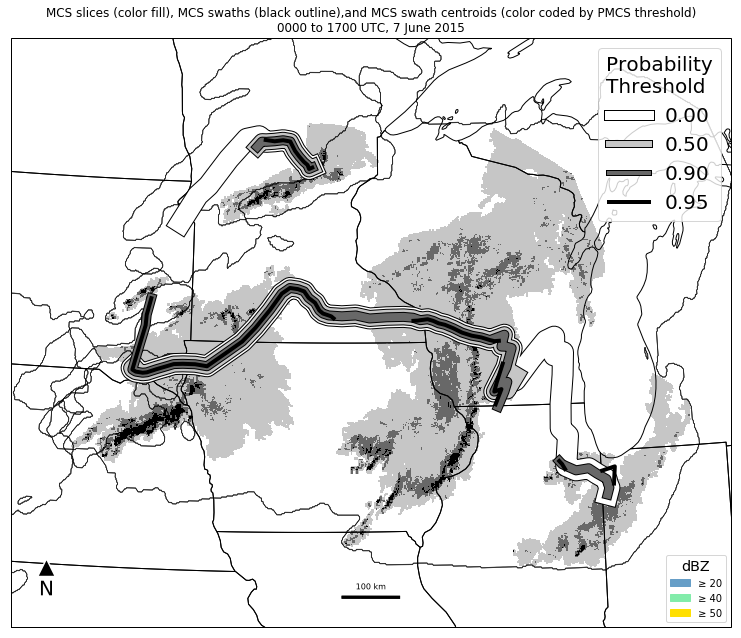

In [3]:
from_proj = ccrs.PlateCarree()

to_proj = ccrs.AlbersEqualArea(central_longitude=-93.0000, central_latitude=38.0000)

crsr = 48
ssr = 192  

stime = datetime.datetime(2015, 6, 7, 0, 0)
etime = datetime.datetime(2015, 6, 7, 17, 0)
        
radar = np.zeros(shape=(1837, 3661), dtype=int)

view = generate_view(w_lon=-100, e_lon=-85, s_lat=39, n_lat=48, 
                     from_proj=from_proj, to_proj=to_proj)

data_dir = "../data/slice_data/2015/"

for prob in [0.0, 0.5, 0.9, 0.95]:

    fn = "../data/track_data/unmatched/2015/2015_"
    fn += str(crsr).zfill(2) + "_" + str(ssr).zfill(3) 
    fn += "_p" + str(int(prob*100)).zfill(2) + ".pkl"
    
    bg = pickle.load(open(fn, 'rb'))
    
    bg = bg[(pd.to_datetime(bg['datetime']) >= stime) & (pd.to_datetime(bg['datetime']) <= etime)]
    
    bg.loc[:, 'filename'] = fix_sliceloc(bg, data_dir)

    grouped = bg.groupby('storm_num')

    for gid, group in grouped:

        track = []

        swath = np.zeros(shape=(1837, 3661), dtype=int)

        if len(group) >= 12 or (len(group) >=2 and 
                                (prob==0.9 or prob==0.95)):

            for count, (rid, row) in enumerate(group.iterrows()):

                xa = np.mean([row['xmin'], row['xmax']])
                ya = np.mean([row['ymin'], row['ymax']])

                x, y = NOWrad_to_lon_lat(np.array([xa]), np.array([ya]))

                track.append((x, y))

                i_fname = row['filename']
                img = imread(i_fname, mode='P')

                y, x = np.where(img > 0)

                swath[row['ymin'] + y, row['xmin'] + x] += img[y, x]

                if prob == 0:
                    if pd.to_datetime(row['datetime']).hour in [3, 10, 16] and \
                       pd.to_datetime(row['datetime']).minute == 0:

                        radar[row['ymin'] + y, row['xmin'] + x] = img[y, x]

            if prob == 0:
                swath = gaussian_filter(swath, 3)
                view.contour(lons, lats, swath > 0, colors=['k',],
                             transform=from_proj, linestyles='-', linewidths=.25)

            track = np.array(track)  

            x, y = track[:, 0], track[:, 1]

            if len(group) >= 4:

                x = running_ave(x, 4)
                y = running_ave(y, 4)

            if prob == 0:
                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size['0.0']+2, transform=from_proj)

                view.plot(x, y, color='w', linestyle='-', 
                          linewidth=size['0.0'], transform=from_proj)
            else:

                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size[str(prob)]+2, transform=from_proj)

                view.plot(x, y, color=colors[str(prob)], 
                          linestyle='-', linewidth=size[str(prob)], 
                          transform=from_proj)

scale_bar(view, to_proj, 100) 

rw = quantize(radar)

rw = np.ma.masked_where(rw==0, rw)

view.pcolormesh(lons, lats, rw, cmap='Greys', transform=from_proj, 
                vmin=0, vmax=3)


leg = view.legend([mpatches.Patch(color='#669EC7'),  
                                mpatches.Patch(color='#82ECAA'), 
                                mpatches.Patch(color='#ffdf00')], 
                                ['≥ 20','≥ 40','≥ 50'], loc=4)

leg.set_title("dBZ", prop = {'size':'x-large'})

add_probability_legend(view)

plt.gca().add_artist(leg)

title = "MCS slices (color fill), MCS swaths (black outline),"
title += "and MCS swath centroids (color coded by PMCS threshold)\n" 
title += "0000 to 1700 UTC, 7 June 2015"

plt.title(title)

# Plot data from 22 June 2015 (00 - 23 UTC)

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001B5219C2258> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


Text(0.5,1,'MCS slices (color fill), MCS swaths (black outline),and MCS swath centroids (color coded by PMCS threshold)\n0000 to 2300 UTC, 22 June 2015')

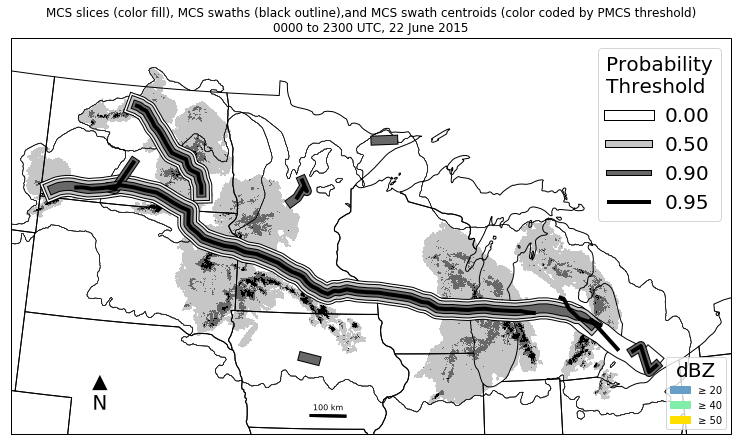

In [4]:
from_proj = ccrs.PlateCarree()

to_proj = ccrs.AlbersEqualArea(central_longitude=-91.0000, central_latitude=38.0000)

crsr = 24
ssr = 96  

stime = datetime.datetime(2015, 6, 22, 0, 0)
etime = datetime.datetime(2015, 6, 22, 23, 0)
        
radar = np.zeros(shape=(1837, 3661), dtype=int)

view = generate_view(w_lon=-104, e_lon=-79, s_lat=40, n_lat=50, 
                     from_proj=from_proj, to_proj=to_proj)

for prob in [0.0, 0.5, 0.9, 0.95]:

    fn = "../data/track_data/unmatched/2015/2015_"
    fn += str(crsr).zfill(2) + "_" + str(ssr).zfill(3) 
    fn += "_p" + str(int(prob*100)).zfill(2) + ".pkl"
    
    bg = pickle.load(open(fn, 'rb'))
    
    bg = bg[(pd.to_datetime(bg['datetime']) >= stime) & (pd.to_datetime(bg['datetime']) <= etime)]
    
    bg.loc[:, 'filename'] = fix_sliceloc(bg, data_dir)
    grouped = bg.groupby('storm_num')

    for gid, group in grouped:

        track = []

        swath = np.zeros(shape=(1837, 3661), dtype=int)

        if len(group) >= 12 or (len(group) >=2 
                                and (prob==0.9 or prob==0.95)):

            for count, (rid, row) in enumerate(group.iterrows()):

                xa = np.mean([row['xmin'], row['xmax']])
                ya = np.mean([row['ymin'], row['ymax']])

                x, y = NOWrad_to_lon_lat(np.array([xa]), np.array([ya]))

                track.append((x, y))

                i_fname = row['filename']
                img = imread(i_fname, mode='P')

                y, x = np.where(img > 0)

                swath[row['ymin'] + y, row['xmin'] + x] += img[y, x]

                if prob == 0:
                    if (pd.to_datetime(row['datetime']).hour in [0, 4, 10, 17, 20] 
                        and pd.to_datetime(row['datetime']).minute == 0):

                        radar[row['ymin'] + y, row['xmin'] + x] = img[y, x]

            if prob == 0:
                swath = gaussian_filter(swath, 3)
                view.contour(lons, lats, swath > 0, colors=['k',], 
                             transform=from_proj, linestyles='-', linewidths=.25)

            track = np.array(track)  

            x, y = track[:, 0], track[:, 1]

            if len(group) >= 8:

                x = running_ave(x, 8)
                y = running_ave(y, 8)

            if prob == 0:
                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size['0.0']+2, transform=from_proj)

                view.plot(x, y, color='w', linestyle='-', 
                          linewidth=size['0.0'], transform=from_proj)
            else:

                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size[str(prob)]+2, transform=from_proj)

                view.plot(x, y, color=colors[str(prob)], 
                          linestyle='-', linewidth=size[str(prob)], transform=from_proj)

scale_bar(view, to_proj, 100) 

rw = quantize(radar)

rw = np.ma.masked_where(rw==0, rw)

view.pcolormesh(lons, lats, rw, cmap='Greys', transform=from_proj, 
                vmin=0, vmax=3)


leg = view.legend([mpatches.Patch(color='#669EC7'),  
                                mpatches.Patch(color='#82ECAA'), 
                                mpatches.Patch(color='#ffdf00')], 
                                ['≥ 20','≥ 40','≥ 50'], loc=4)

leg.set_title("dBZ", prop = {'size':20})

add_probability_legend(view)

plt.gca().add_artist(leg)

title = "MCS slices (color fill), MCS swaths (black outline),"
title += "and MCS swath centroids (color coded by PMCS threshold)\n" 
title += "0000 to 2300 UTC, 22 June 2015"

plt.title(title)

# Plot data from 24-25 June 2015 (23 - 18 UTC)

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001B51C975200> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


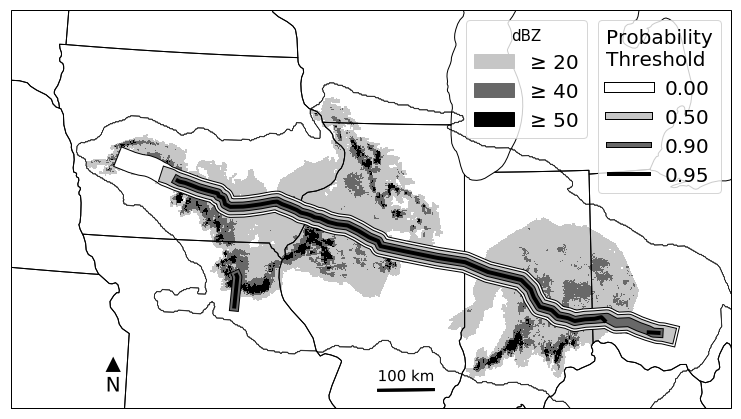

In [5]:
from_proj = ccrs.PlateCarree()

to_proj = ccrs.AlbersEqualArea(central_longitude=-88.0000, central_latitude=38.0000)

crsr = 24
ssr = 96  

stime = datetime.datetime(2015, 6, 24, 23, 0)
etime = datetime.datetime(2015, 6, 25, 18, 0)
        
radar = np.zeros(shape=(1837, 3661), dtype=int)

view = generate_view(w_lon=-97, e_lon=-82, s_lat=38, n_lat=44, 
                     from_proj=from_proj, to_proj=to_proj)

for prob in [0.0, 0.5, 0.9, 0.95]:

    fn = "../data/track_data/unmatched/2015/2015_"
    fn += str(crsr).zfill(2) + "_" + str(ssr).zfill(3) 
    fn += "_p" + str(int(prob*100)).zfill(2) + ".pkl"
    
    bg = pickle.load(open(fn, 'rb'))
    
    bg = bg[(pd.to_datetime(bg['datetime']) >= stime) & (pd.to_datetime(bg['datetime']) <= etime)]
    
    bg.loc[:, 'filename'] = fix_sliceloc(bg, data_dir)
    grouped = bg.groupby('storm_num')

    for gid, group in grouped:

        track = []

        swath = np.zeros(shape=(1837, 3661), dtype=int)

        if len(group) >= 12 or (len(group) >=2 and 
                                (prob==0.9 or prob==0.95)):

            for count, (rid, row) in enumerate(group.iterrows()):

                xa = np.mean([row['xmin'], row['xmax']])
                ya = np.mean([row['ymin'], row['ymax']])

                x, y = NOWrad_to_lon_lat(np.array([xa]), np.array([ya]))

                track.append((x, y))

                i_fname = row['filename']
                img = imread(i_fname, mode='P')

                y, x = np.where(img > 0)

                swath[row['ymin'] + y, row['xmin'] + x] += img[y, x]

                if prob == 0:
                    if pd.to_datetime(row['datetime']).hour in [6, 12] and \
                       pd.to_datetime(row['datetime']).minute == 0:

                        radar[row['ymin'] + y, row['xmin'] + x] = img[y, x]

            if prob == 0:
                swath = gaussian_filter(swath, 3)
                view.contour(lons, lats, swath > 0, colors=['k',], 
                             transform=from_proj, linestyles='-', linewidths=.25)

            track = np.array(track)  

            x, y = track[:, 0], track[:, 1]

            if len(group) >= 4:

                x = running_ave(x, 4)
                y = running_ave(y, 4)

            if prob == 0:
                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size['0.0']+2, transform=from_proj)

                view.plot(x, y, color='w', linestyle='-', 
                          linewidth=size['0.0'], transform=from_proj)
            else:

                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size[str(prob)]+2, transform=from_proj)

                view.plot(x, y, color=colors[str(prob)], 
                          linestyle='-', linewidth=size[str(prob)], transform=from_proj)

scale_bar(view, to_proj, 100, fontsize=15) 

rw = quantize(radar)

rw = np.ma.masked_where(rw==0, rw)

view.pcolormesh(lons, lats, rw, cmap=cmap, transform=from_proj, vmin=0, vmax=3)


leg = view.legend([mpatches.Patch(color=cmap(1/3)),  
                                mpatches.Patch(color=cmap(2/3)), 
                                mpatches.Patch(color=cmap(3/3))], 
                                ['≥ 20','≥ 40','≥ 50'], prop={'size': 20},
                                bbox_to_anchor=(.8, .975), loc=1, borderaxespad=0.)

leg.set_title("dBZ", prop = {'size':15})

add_probability_legend(view)

plt.gca().add_artist(leg)

# Plot rematched data from 7 June 2015 (00 - 17 UTC)

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001B51C970150> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


Text(0.5,1,'MCS slices (color fill), Rematched MCS swaths (black outline),and Rematched MCS swath centroids (color coded by PMCS threshold)\n0000 to 1700 UTC, 7 June 2015')

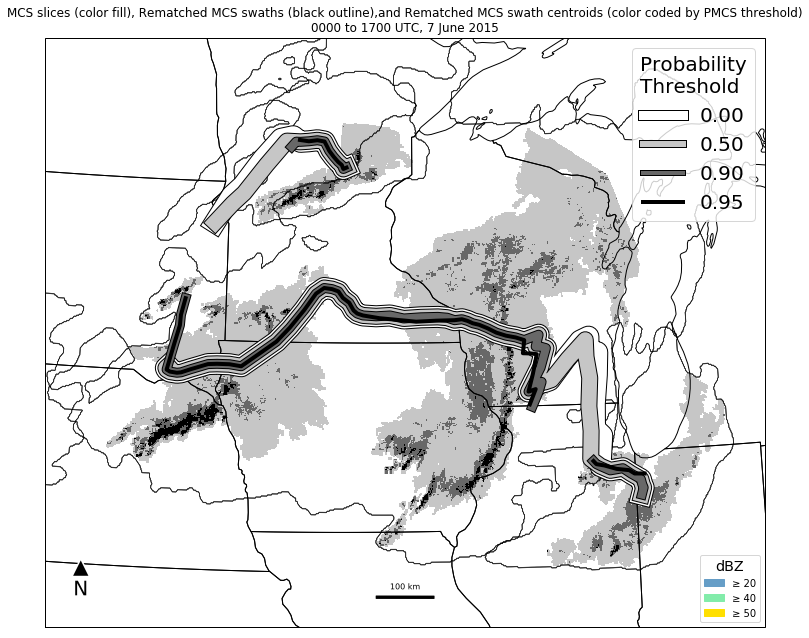

In [6]:
from_proj = ccrs.PlateCarree()

to_proj = ccrs.AlbersEqualArea(central_longitude=-93.0000, central_latitude=38.0000)

crsr = 48
ssr = 192 

stime = datetime.datetime(2015, 6, 7, 0, 0)
etime = datetime.datetime(2015, 6, 7, 17, 0)
        
radar = np.zeros(shape=(1837, 3661), dtype=int)

view = generate_view(w_lon=-100, e_lon=-85, s_lat=39, n_lat=48, 
                     from_proj=from_proj, to_proj=to_proj)

for prob in [0.0, 0.5, 0.9, 0.95]:

    fn = "../data/track_data/rematched/2015/2015_"
    fn += str(crsr).zfill(2) + "_" + str(ssr).zfill(3) 
    fn += "_p" + str(int(prob*100)).zfill(2) + ".pkl"
    
    bg = pickle.load(open(fn, 'rb'))
    
    bg = bg[(pd.to_datetime(bg['datetime']) >= stime) & (pd.to_datetime(bg['datetime']) <= etime)]
    
    bg.loc[:, 'filename'] = fix_sliceloc(bg, data_dir)
    grouped = bg.groupby('storm_num')

    for gid, group in grouped:

        track = []

        swath = np.zeros(shape=(1837, 3661), dtype=int)

        if len(group) >= 12 or (len(group) >=2 and (prob==0.9 or prob==0.95)):

            for count, (rid, row) in enumerate(group.iterrows()):

                xa = np.mean([row['xmin'], row['xmax']])
                ya = np.mean([row['ymin'], row['ymax']])

                x, y = NOWrad_to_lon_lat(np.array([xa]), np.array([ya]))

                track.append((x, y))

                i_fname = row['filename']
                img = imread(i_fname, mode='P')

                y, x = np.where(img > 0)

                swath[row['ymin'] + y, row['xmin'] + x] += img[y, x]

                if prob == .9:
                    if pd.to_datetime(row['datetime']).hour in [3, 10, 16] and \
                       pd.to_datetime(row['datetime']).minute == 0:

                        radar[row['ymin'] + y, row['xmin'] + x] = img[y, x]

            if prob == .9:
                swath = gaussian_filter(swath, 3)
                view.contour(lons, lats, swath > 0, colors=['k',], transform=from_proj, linestyles='-', linewidths=.25)

            track = np.array(track)  

            x, y = track[:, 0], track[:, 1]

            if len(group) >= 4:

                x = running_ave(x, 4)
                y = running_ave(y, 4)

            if prob == 0:
                view.plot(x, y, color='k', linestyle='-', linewidth=size['0.0']+2, transform=from_proj)

                view.plot(x, y, color='w', linestyle='-', linewidth=size['0.0'], transform=from_proj)
            else:

                view.plot(x, y, color='k', linestyle='-', linewidth=size[str(prob)]+2, transform=from_proj)

                view.plot(x, y, color=colors[str(prob)], linestyle='-', linewidth=size[str(prob)], transform=from_proj)

scale_bar(view, to_proj, 100) 

rw = quantize(radar)

rw = np.ma.masked_where(rw==0, rw)

view.pcolormesh(lons, lats, rw, cmap='Greys', transform=from_proj, vmin=0, vmax=3)


leg = view.legend([mpatches.Patch(color='#669EC7'),  
                                mpatches.Patch(color='#82ECAA'), 
                                mpatches.Patch(color='#ffdf00')], 
                                ['≥ 20','≥ 40','≥ 50'], loc=4)

leg.set_title("dBZ", prop = {'size':'x-large'})

add_probability_legend(view)

plt.gca().add_artist(leg)

title = "MCS slices (color fill), Rematched MCS swaths (black outline),"
title += "and Rematched MCS swath centroids (color coded by PMCS threshold)\n" 
title += "0000 to 1700 UTC, 7 June 2015"

plt.title(title)

# Plot rematched data from 22 June 2015 (00 - 23 UTC)

C:\Users\ahaberlie\Anaconda3\envs\py35\lib\site-packages\cartopy\mpl\geoaxes.py:623: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001B51EA1E410> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


Text(0.5,1,'MCS slices (color fill), Rematched MCS swaths (black outline),and Rematched MCS swath centroids (color coded by PMCS threshold)\n0000 to 2300 UTC, 22 June 2015')

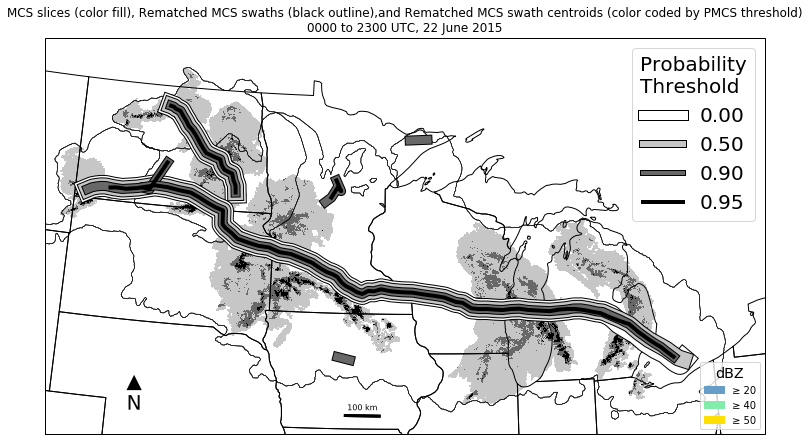

In [7]:
from_proj = ccrs.PlateCarree()

to_proj = ccrs.AlbersEqualArea(central_longitude=-91.0000, central_latitude=38.0000)

crsr = 24
ssr = 96  
        
stime = datetime.datetime(2015, 6, 22, 0, 0)
etime = datetime.datetime(2015, 6, 22, 23, 0)

radar = np.zeros(shape=(1837, 3661), dtype=int)

view = generate_view(w_lon=-104, e_lon=-79, s_lat=40, n_lat=50, 
                     from_proj=from_proj, to_proj=to_proj)

for prob in [0.0, 0.5, 0.9, 0.95]:

    fn = "../data/track_data/rematched/2015/2015_"
    fn += str(crsr).zfill(2) + "_" + str(ssr).zfill(3) 
    fn += "_p" + str(int(prob*100)).zfill(2) + ".pkl"
    
    bg = pickle.load(open(fn, 'rb'))
    
    bg = bg[(pd.to_datetime(bg['datetime']) >= stime) & (pd.to_datetime(bg['datetime']) <= etime)]
    
    bg.loc[:, 'filename'] = fix_sliceloc(bg, data_dir)

    grouped = bg.groupby('storm_num')

    for gid, group in grouped:

        track = []

        swath = np.zeros(shape=(1837, 3661), dtype=int)

        if len(group) >= 12 or (len(group) >=2 and (prob==0.9 or prob==0.95)):

            for count, (rid, row) in enumerate(group.iterrows()):

                xa = np.mean([row['xmin'], row['xmax']])
                ya = np.mean([row['ymin'], row['ymax']])

                x, y = NOWrad_to_lon_lat(np.array([xa]), np.array([ya]))

                track.append((x, y))

                i_fname = row['filename']
                img = imread(i_fname, mode='P')

                y, x = np.where(img > 0)

                swath[row['ymin'] + y, row['xmin'] + x] += img[y, x]

                if prob == 0:
                    if pd.to_datetime(row['datetime']).hour in [0, 4, 10, 17, 20] and \
                       pd.to_datetime(row['datetime']).minute == 0:

                        radar[row['ymin'] + y, row['xmin'] + x] = img[y, x]

            if prob == 0:
                swath = gaussian_filter(swath, 3)
                view.contour(lons, lats, swath > 0, colors=['k',], 
                             transform=from_proj, linestyles='-', linewidths=.25)

            track = np.array(track)  

            x, y = track[:, 0], track[:, 1]

            if len(group) >= 8:

                x = running_ave(x, 8)
                y = running_ave(y, 8)

            if prob == 0:
                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size['0.0']+2, transform=from_proj)

                view.plot(x, y, color='w', linestyle='-', 
                          linewidth=size['0.0'], transform=from_proj)
            else:

                view.plot(x, y, color='k', linestyle='-', 
                          linewidth=size[str(prob)]+2, transform=from_proj)

                view.plot(x, y, color=colors[str(prob)], linestyle='-', 
                          linewidth=size[str(prob)], transform=from_proj)

scale_bar(view, to_proj, 100) 

rw = quantize(radar)

rw = np.ma.masked_where(rw==0, rw)

view.pcolormesh(lons, lats, rw, cmap='Greys', 
                transform=from_proj, vmin=0, vmax=3)


leg = view.legend([mpatches.Patch(color='#669EC7'),  
                                mpatches.Patch(color='#82ECAA'), 
                                mpatches.Patch(color='#ffdf00')], 
                                ['≥ 20','≥ 40','≥ 50'], loc=4)

leg.set_title("dBZ", prop = {'size':'x-large'})

add_probability_legend(view)

plt.gca().add_artist(leg)

title = "MCS slices (color fill), Rematched MCS swaths (black outline),"
title += "and Rematched MCS swath centroids (color coded by PMCS threshold)\n" 
title += "0000 to 2300 UTC, 22 June 2015"

plt.title(title)

In [8]:
import pandas as pd
import numpy as np
import pickle

def duration(x):

    return (x[-1] - x[0]).total_seconds() / 3600


dc = {'Year':[], 'CRSR':[], 'SSR':[], 'MCS_proba':[], 'Swaths':[], 'Slices':[], 'Percent':[]}

for year in range(2015, 2017):
    for p in [0.0, 0.5, 0.9, 0.95]:
        for crsr in [6, 12, 24, 48]:
            for ssr in [48, 96, 192]:

                fn = "../data/track_data/rematched/" + str(year) + "/" + str(year) + "_" 
                fn += str(crsr).zfill(2) + "_" + str(ssr).zfill(3) + "_p" + str(int(p*100)).zfill(2) + ".pkl"

                df = pickle.load(open(fn, 'rb'))

                df = df[df.major_axis_length >= 100]

                df['duration'] = 0.0

                df['datetime'] = pd.to_datetime(df.datetime)
                df = df.set_index('datetime')

                grouped = df.groupby('storm_num')

                df['duration'] = grouped['storm_num'].transform(lambda x: duration(x.index))

                df_long = df[df.duration >= 3]

                grouped = df_long.groupby('storm_num')

                dc['Year'].append(year)
                dc['CRSR'].append(crsr)
                dc['SSR'].append(ssr)
                dc['MCS_proba'].append(p)
                dc['Swaths'].append(len(grouped))
                dc['Slices'].append(len(df_long))
                dc['Percent'].append(100*(len(df_long) / len(df)))

swath_stats = pd.DataFrame.from_dict(dc)

grouped = swath_stats.groupby('Year')

for gid, group in grouped:
    
    probas = group.groupby('MCS_proba')
    
    for pid, proba in probas:
    
        print(proba[['Year', 'CRSR', 'SSR', 'MCS_proba', 'Swaths', 'Slices', 'Percent']])

    Year  CRSR  SSR  MCS_proba  Swaths  Slices    Percent
0   2015     6   48        0.0     955   23988  55.217181
1   2015     6   96        0.0     885   23773  57.813716
2   2015     6  192        0.0     837   23580  59.446377
3   2015    12   48        0.0    1182   30224  55.962080
4   2015    12   96        0.0    1071   29475  57.435987
5   2015    12  192        0.0    1033   29241  58.685050
6   2015    24   48        0.0    1581   40552  57.567111
7   2015    24   96        0.0    1469   39686  58.958284
8   2015    24  192        0.0    1414   39224  59.650830
9   2015    48   48        0.0    2087   54239  60.689709
10  2015    48   96        0.0    1946   52904  61.674050
11  2015    48  192        0.0    1877   52045  61.812632
    Year  CRSR  SSR  MCS_proba  Swaths  Slices    Percent
12  2015     6   48        0.5     520   13851  66.495439
13  2015     6   96        0.5     591   16995  67.502085
14  2015     6  192        0.5     605   17490  68.915245
15  2015    12